In [ ]:
import os
import sys
if "../" not in sys.path:
    sys.path.append("../")
from pathlib import Path
from typing import List, Optional
from src.kharkan.modelKAN import KharKAN, _clean_expr
from src.kharkan.NMR import get_frequences_ordered
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from ipywidgets import Checkbox, HBox, VBox, interactive_output
import numpy as np


In [ ]:
def f2(x: np.ndarray) -> np.ndarray:
    return np.array(get_frequences_ordered(x[:, 0], x[:, 1]))

def make_dataset(num_samples: int):
    samples = []
    while len(samples) < num_samples:
        batch = int((num_samples - len(samples)) * 1.5) + 10
        x0 = -np.abs(np.random.rand(batch) * 27 + 5)
        x1 = -np.abs(np.random.rand(batch) * 14.9 + 0.1)
        r0 = x0 / x1
        r1 = x1 / x0
        mask = (
            (np.abs(r0) < 10) & (np.abs(r1) < 10)
            & (np.abs(x0) < 10) & (np.abs(x1) < 10)
        )
        x0, x1, r0, r1 = x0[mask], x1[mask], r0[mask], r1[mask]
        for i in range(len(x0)):
            samples.append([x0[i], x1[i], r0[i], r1[i]])
    arr = np.array(samples[:num_samples])
    labels = f2(arr[:, :2])
    inputs = torch.tensor(arr, dtype=torch.float)
    targets = torch.tensor(labels, dtype=torch.float)
    return inputs, targets
def perturb_theory(Jintra, deltaJ):
    """
    Perturb the theory by adding a small random noise to the intra-molecular coupling constant.
    """
    F1=np.sqrt(2)*deltaJ
    F2=deltaJ/np.sqrt(2)- deltaJ**2/8/Jintra
    F3=deltaJ/np.sqrt(2)+ deltaJ**2/8/Jintra
    return F1, F2, F3

In [ ]:
dataset = make_dataset(10000)

In [ ]:
dataset[0].shape, dataset[1].shape
Xsez= dataset[0][...,:2]
Ysez = dataset[1][...,:3]
Ysez_perturbed = perturb_theory(Xsez[:, 0], Xsez[:, 1])

Text(0.5, 0.5, 'delta J')

Text(0.5, 0.5, 'delta J')

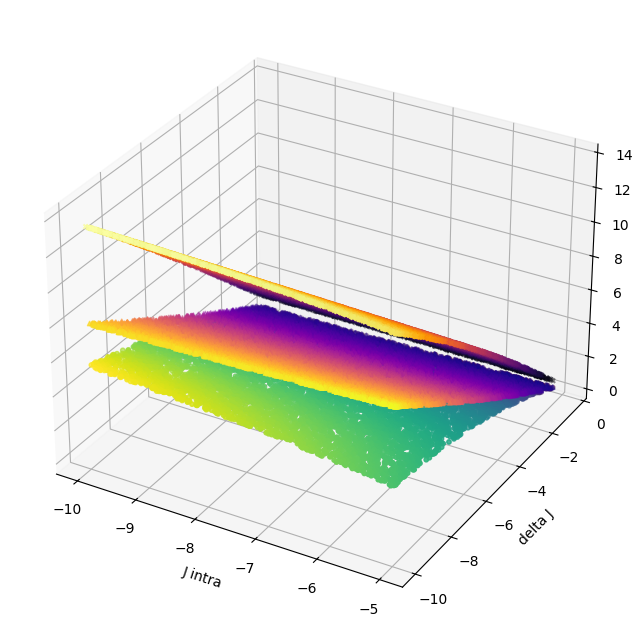

In [ ]:

# plot 3d scatter plot with different colors for each Y class
# X0 is Jintra, X1 is deltaJ
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xsez[:, 0], Xsez[:, 1], Ysez[:, 0], c=Ysez[:, 0], cmap='viridis', s=10)
ax.scatter(Xsez[:, 0], Xsez[:, 1], Ysez[:, 1], c=Ysez[:, 1], cmap='plasma', s=10, marker='^')
ax.scatter(Xsez[:, 0], Xsez[:, 1], Ysez[:, 2], c=Ysez[:, 2], cmap='inferno', s=10, marker='x')
ax.set_xlabel('J intra')
ax.set_ylabel('delta J')

# Interactive 3D Comparison: Data vs Perturbation Theory
This cell provides an interactive 3D plot to compare the three Y components from the dataset and from perturbation theory. Use the checkboxes to show or hide each set.

In [ ]:
%matplotlib qt
# Prepare data
x = Xsez[:, 0].numpy() if hasattr(Xsez[:, 0], 'numpy') else Xsez[:, 0]
y = Xsez[:, 1].numpy() if hasattr(Xsez[:, 1], 'numpy') else Xsez[:, 1]
Y = Ysez.numpy() if hasattr(Ysez, 'numpy') else Ysez
Yp = np.vstack([a if isinstance(a, np.ndarray) else a.numpy() for a in Ysez_perturbed]).T

# Checkboxes for each plot
cb_y0 = Checkbox(value=True, description='Y0 (Data)', indent=False)
cb_y1 = Checkbox(value=True, description='Y1 (Data)', indent=False)
cb_y2 = Checkbox(value=True, description='Y2 (Data)', indent=False)
cb_p0 = Checkbox(value=True, description='Y0 (Perturbation)', indent=False)
cb_p1 = Checkbox(value=True, description='Y1 (Perturbation)', indent=False)
cb_p2 = Checkbox(value=True, description='Y2 (Perturbation)', indent=False)

# Plotting function
def plot_3d(y0, y1, y2, p0, p1, p2):
    fig = go.Figure()
    if y0:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Y[:, 0], mode='markers', marker=dict(size=2, color=Y[:, 0], colorscale='Viridis'), name='Y0 (Data)'))
    if y1:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Y[:, 1], mode='markers', marker=dict(size=2, color=Y[:, 1], colorscale='Plasma', symbol='diamond'), name='Y1 (Data)'))
    if y2:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Y[:, 2], mode='markers', marker=dict(size=2, color=Y[:, 2], colorscale='Inferno', symbol='x'), name='Y2 (Data)'))
    if p0:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Yp[:, 0], mode='markers', marker=dict(size=2, color=Yp[:, 0], colorscale='Viridis', opacity=0.5), name='Y0 (Perturbation)'))
    if p1:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Yp[:, 1], mode='markers', marker=dict(size=2, color=Yp[:, 1], colorscale='Plasma', symbol='diamond', opacity=0.5), name='Y1 (Perturbation)'))
    if p2:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=Yp[:, 2], mode='markers', marker=dict(size=2, color=Yp[:, 2], colorscale='Inferno', symbol='x', opacity=0.5), name='Y2 (Perturbation)'))
    fig.update_layout(
        scene=dict(
            xaxis_title='J intra',
            yaxis_title='delta J',
            zaxis_title='Frequency',
        ),
        legend_title_text='Legend',
        height=700,
        width=900,
        title='Interactive 3D Comparison: Data vs Perturbation Theory',
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()

ui = VBox([
    HBox([cb_y0, cb_y1, cb_y2]),
    HBox([cb_p0, cb_p1, cb_p2])
])
out = interactive_output(plot_3d, {'y0': cb_y0, 'y1': cb_y1, 'y2': cb_y2, 'p0': cb_p0, 'p1': cb_p1, 'p2': cb_p2})
display(ui, out)

UsageError: Line magic function `%` not found.
